In [117]:
import h5py
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [118]:
#load the data
with h5py.File('data/background_for_training.h5', 'r') as f:
    X = f['Particles'][:100000]  #will load more if this works

In [119]:
#must flatten data so it is 1D per event
X = X.reshape(X.shape[0], -1)

#take out any NaN
X = np.nan_to_num(X)

#scale it
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)

#make torch tensor
X_tensor = torch.tensor(X_scaled)

In [120]:
#standard vae model class
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim=16):
        super().__init__()

        #the encoder (maps input to hidden layer, then to mu and logvar)
        self.encoder = nn.Sequential(

            #input to hidden layer
            nn.Linear(input_dim, 64),

            #activation function
            nn.ReLU(),

            #outputs mu and logvar
            nn.Linear(64, 2 * latent_dim)
        )

        #decoder (maps latent vector z back to recon. input)
        self.decoder = nn.Sequential(

            #latent to hidden layer
            nn.Linear(latent_dim, 64),

            #act. function
            nn.ReLU(),

            #hidden to recon. inputp
            nn.Linear(64, input_dim)
        )

    #this encodes input z into latent params (mu and logvar)
    def encode(self, x):

        #shape is [batch_size, 2*latent_dim]
        h = self.encoder(x)

        #splits into mu and logvar on last dimension
        mu, logvar = h.chunk(2, dim=-1)
        return mu, logvar

    #samples latent var z with reparam trick (z = mu + std*(~N(0,1))
    #this allows gradient propagation
    def reparameterize(self, mu, logvar):
        std = (0.5 * logvar).exp()
        eps = torch.randn_like(std)

        #reparam latent sample
        return mu + eps * std

    #decodes latent var z into input space
    def decode(self, z):
        return self.decoder(z)

    #VAE forward pass
    def forward(self, x):

        #encode input to mu and logvar
        mu, logvar = self.encode(x)

        #sample z via reparameterize
        z = self.reparameterize(mu, logvar)

        #decode z to recon input
        x_hat = self.decode(z)
        return x_hat, mu, logvar, z


In [121]:
#get the distance correlation (DisCo) given and x and y var
#this is from the paper
def disco_loss(x, y):
    x = x - x.mean(0)
    y = y - y.mean(0)
    a = torch.cdist(x, x)
    b = torch.cdist(y, y)
    A = a - a.mean(0) - a.mean(1, keepdim=True) + a.mean()
    B = b - b.mean(0) - b.mean(1, keepdim=True) + b.mean()
    dcov = (A * B).mean()
    dvar_x = (A * A).mean().sqrt()
    dvar_y = (B * B).mean().sqrt()
    return dcov / (dvar_x.detach() * dvar_y.detach() + 1e-10) #in case of zero in denom

In [122]:
#calculate loss for vae (mse and kl div)
def vae_loss(x, x_hat, mu, logvar):
    
    #reco loss
    recon = F.mse_loss(x_hat, x, reduction='mean')
    
    #kl divergence
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl_div

In [123]:
#combining vae loss and disco loss
def total_loss(x, out_1, out_2, lambda_disco=10000):

    #output from VAE 1
    x1_hat, mu_1, logvar_1, z_1 = out_1

    #output from VAE 2
    x2_hat, mu_2, logvar_2, z_2 = out_2

    #calc vae loss
    loss_1 = vae_loss(x, x1_hat, mu_1, logvar_1)
    loss_2 = vae_loss(x, x2_hat, mu_2, logvar_2)


    #calc distance corr between latent vectors z_1 and z_2
    disco = disco_loss(z_1, z_2)

    #sum loss (keep in mind disco term penalizes corr between latent spaces
    #to force decorrelation)
    return loss_1 + loss_2 + lambda_disco * disco

In [124]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#init both vaes
vae_1 = VAE(X_tensor.shape[1]).to(device)
vae_2 = VAE(X_tensor.shape[1]).to(device)

#optimizer with Adam for both models
optimizer = torch.optim.Adam(list(vae_1.parameters()) + list(vae_2.parameters()), lr=1e-3)

In [125]:
#training hyperparams
batch_size = 256
epochs = 500

#lists for plotting loss
loss_list = []
vae_1_list = []
vae_2_list = []
disco_list = []

#train the VAEs
for epoch in range(epochs):
    
    #shuffle data after each epoch
    perm = torch.randperm(X_tensor.size(0))

    #initialize loss trackers
    final_loss = 0
    total_disco = 0
    total_vae_1 = 0
    total_vae_2 = 0

    #iterate through the dataset in mini batches
    for i in range(0, X_tensor.size(0), batch_size):
        
        #shuffled mini batch
        x_batch = X_tensor[perm[i:i+batch_size]]

        #forward pass through both VAEs
        out_1 = vae_1(x_batch)
        out_2 = vae_2(x_batch)

        #get outputs
        x1_hat, mu1, logvar1, z1 = out_1
        x2_hat, mu2, logvar2, z2 = out_2

        #compute VAE losses
        loss1 = vae_loss(x_batch, x1_hat, mu1, logvar1)
        loss2 = vae_loss(x_batch, x2_hat, mu2, logvar2)

        #compute disco
        disco = disco_loss(z1, z2)

        #compute total loss with weighting
        loss = loss1 + loss2 + 10000 * disco

        #zero gradients
        optimizer.zero_grad()

        #backward pass (gradient propagation)
        loss.backward()

        #update params
        optimizer.step()

        #add to total losses
        final_loss += loss.item()
        total_disco += disco.item()
        total_vae_1 += loss1.item()
        total_vae_2 += loss2.item()

    print(f"Epoch {epoch} : Loss = {final_loss:.2f} | vae_1 = {total_vae_1:.2f} | vae_2 = {total_vae_2:.2f} | DisCo = {total_disco:.4f}")

    loss_list.append(final_loss)
    vae_1_list.append(total_vae_1)
    vae_2_list.append(total_vae_2)
    disco_list.append(total_disco)


Epoch 0 : Loss = 884449.55 | vae_1 = 1353.51 | vae_2 = 2463.97 | DisCo = 88.0632
Epoch 1 : Loss = 1010624.26 | vae_1 = 1980.54 | vae_2 = 2232.33 | DisCo = 100.6411
Epoch 2 : Loss = 983606.50 | vae_1 = 2188.56 | vae_2 = 2409.25 | DisCo = 97.9009
Epoch 3 : Loss = 972476.22 | vae_1 = 2303.33 | vae_2 = 2512.89 | DisCo = 96.7660
Epoch 4 : Loss = 923865.48 | vae_1 = 2404.51 | vae_2 = 2560.40 | DisCo = 91.8901
Epoch 5 : Loss = 918875.32 | vae_1 = 2463.19 | vae_2 = 2640.63 | DisCo = 91.3771
Epoch 6 : Loss = 878689.59 | vae_1 = 2519.15 | vae_2 = 2689.04 | DisCo = 87.3481
Epoch 7 : Loss = 888541.68 | vae_1 = 2573.40 | vae_2 = 2719.71 | DisCo = 88.3249
Epoch 8 : Loss = 846215.28 | vae_1 = 2646.48 | vae_2 = 2772.28 | DisCo = 84.0797
Epoch 9 : Loss = 831438.59 | vae_1 = 2689.15 | vae_2 = 2779.83 | DisCo = 82.5970
Epoch 10 : Loss = 844551.60 | vae_1 = 2719.16 | vae_2 = 2809.86 | DisCo = 83.9023
Epoch 11 : Loss = 851111.96 | vae_1 = 2759.61 | vae_2 = 2854.29 | DisCo = 84.5498
Epoch 12 : Loss = 858340

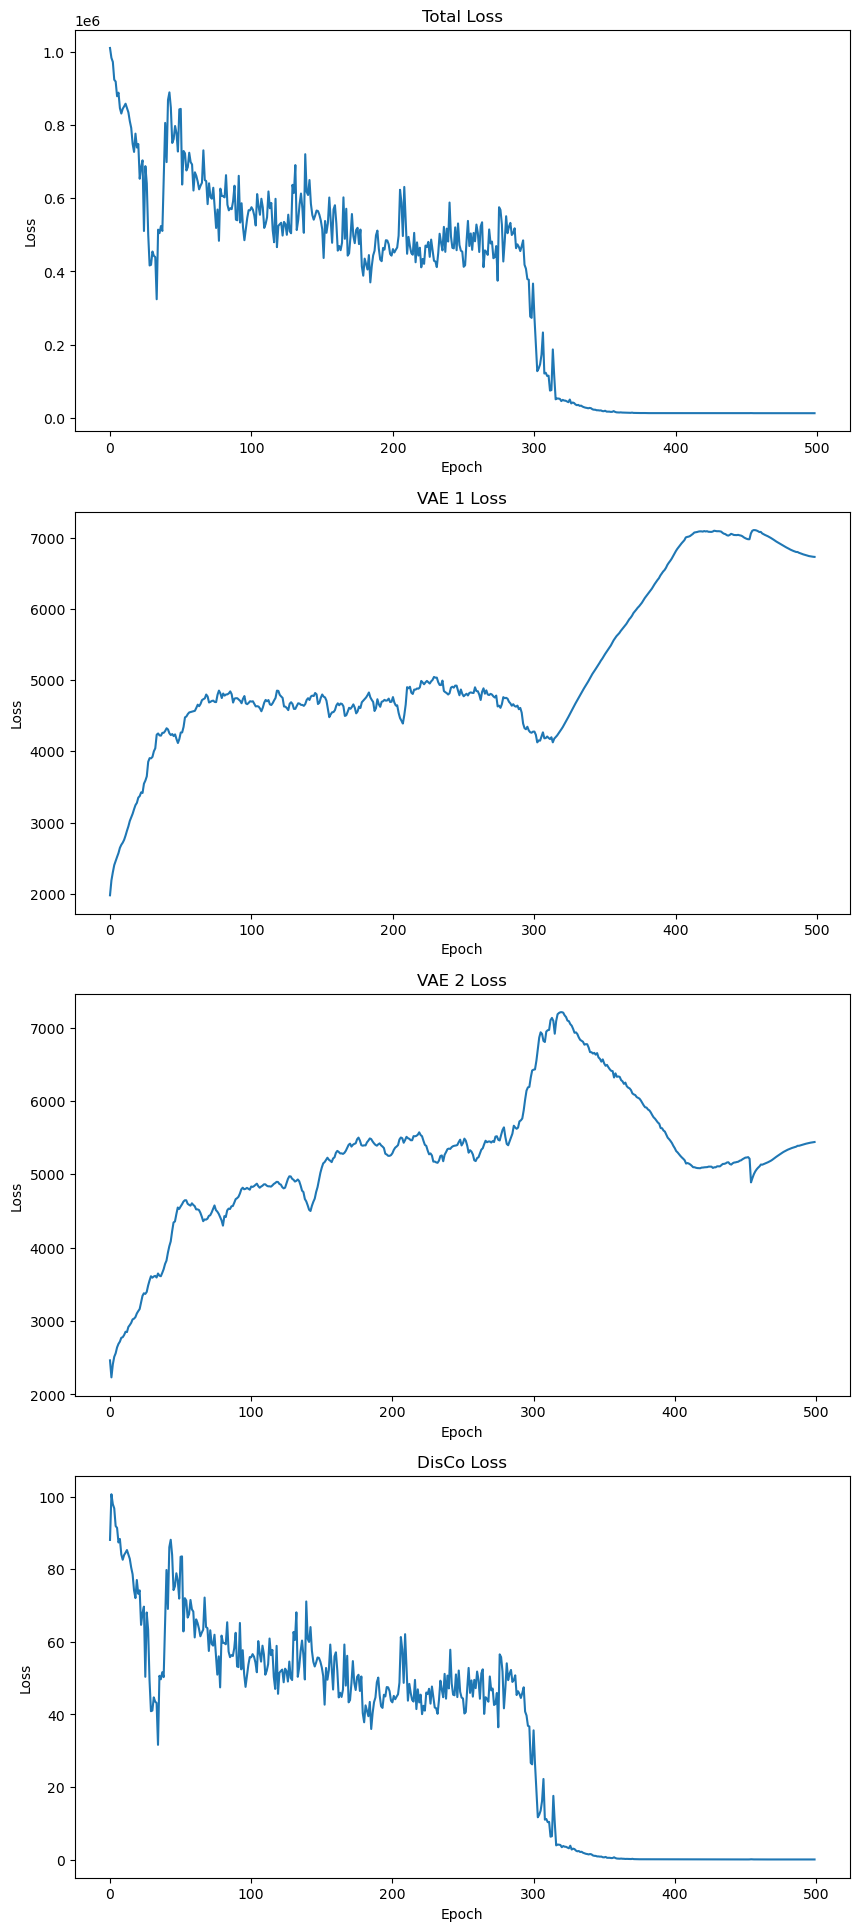

In [126]:
plt.figure(figsize=(10, 24))

plt.subplot(4, 1, 1)
plt.plot(loss_list[1:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Total Loss')

plt.subplot(4, 1, 2)
plt.plot(vae_1_list[1:])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE 1 Loss')

plt.subplot(4, 1, 3)
plt.plot(vae_2_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE 2 Loss')

plt.subplot(4, 1, 4)
plt.plot(disco_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('DisCo Loss')

plt.show()
